# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 10 октября 2023, 23:59

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [2]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   --------- ----------------------------- 71.7/294.9 kB 787.7 kB/s eta 0:00:01
   --------------------------- ------------ 204.8/294.9 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Alexey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [4]:
from sklearn.neighbors import KDTree

class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):

        self.k = n_neighbors
        self.X = None
        self.y = None
        self.algorithm = algorithm
        self.tree = None
    
    def fit(self, X, y):

        self.X = X
        self.y = y

        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X) 
    
    def predict(self, X):
        
        if self.algorithm not in ['brute', 'kd_tree']:
            raise NotImplementedError
        
        if self.algorithm == 'brute':
            y = []
            m = X.shape[0]
            n = self.X.shape[0]
            x2 = np.sum(X**2, axis=1).reshape((m, 1))
            y2 = np.sum(self.X**2, axis=1).reshape((1, n))
            xy = X.dot(self.X.T) # (m, n)
            distances = np.sqrt(x2 + y2 - 2*xy) # (m, n)
            
            for i, x in enumerate(X):
                indices = np.argsort(distances[i])[:self.k]
                classes = self.y[indices]
                answer = max(classes, key=lambda x: list(classes).count(x))
                y.append(answer)
            return y
        
        elif self.algorithm == 'kd_tree':
            distances, indices = self.tree.query(X, k=self.k)
            classes = []
            y = []
            for i in range(X.shape[0]):
                classes.append(self.y[indices[i]])
                answer = max(classes[i], key=lambda x: list(classes[i]).count(x))
                y.append(answer)
            return y


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [5]:
iris = datasets.load_iris()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [25]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [26]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [27]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [28]:
%timeit clf.fit(X_train, y_train)

146 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%timeit my_clf.fit(X_train, y_train)

54.3 ns ± 0.718 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [30]:
%timeit clf.predict(X_test)

1.52 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit my_clf.predict(X_test)

79.5 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [32]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [34]:
%time clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 1.14 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [35]:
%time my_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [36]:
%time clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 6.01 ms


array([2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 1, 1, 0, 1])

In [37]:
%time my_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 999 µs


[2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 1, 1, 0, 1]

In [38]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [70]:
newsgroups = fetch_20newsgroups(subset='train',remove=('headers','footers', 'quotes'))

In [42]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
vectorizer = CountVectorizer()

In [45]:
data = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [46]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso

In [48]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [49]:
cv_results = cross_validate(clf, data, target, cv=3, scoring='accuracy')

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [50]:
accs = []
for k in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    cv_results = cross_validate(clf, data, target, cv=3, scoring='accuracy')
    accs.append(cv_results['test_score'].mean())

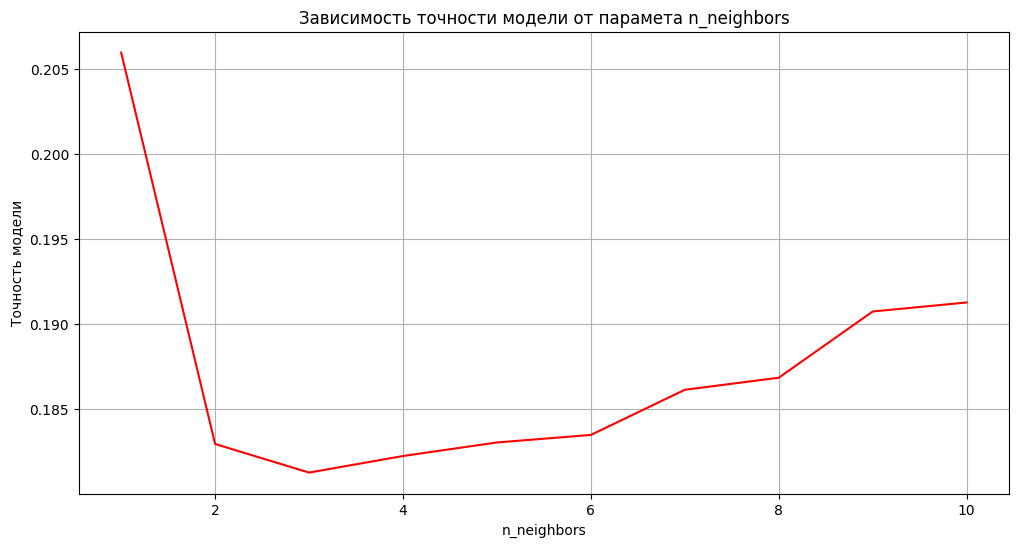

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(list(range(1, 11)), accs, 'red')
plt.title("Зависимость точности модели от парамета n_neighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Точность модели")
plt.grid()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [52]:
accs = []
for k in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='cosine')
    cv_results = cross_validate(clf, data, target, cv=3, scoring='accuracy')
    accs.append(cv_results['test_score'].mean())

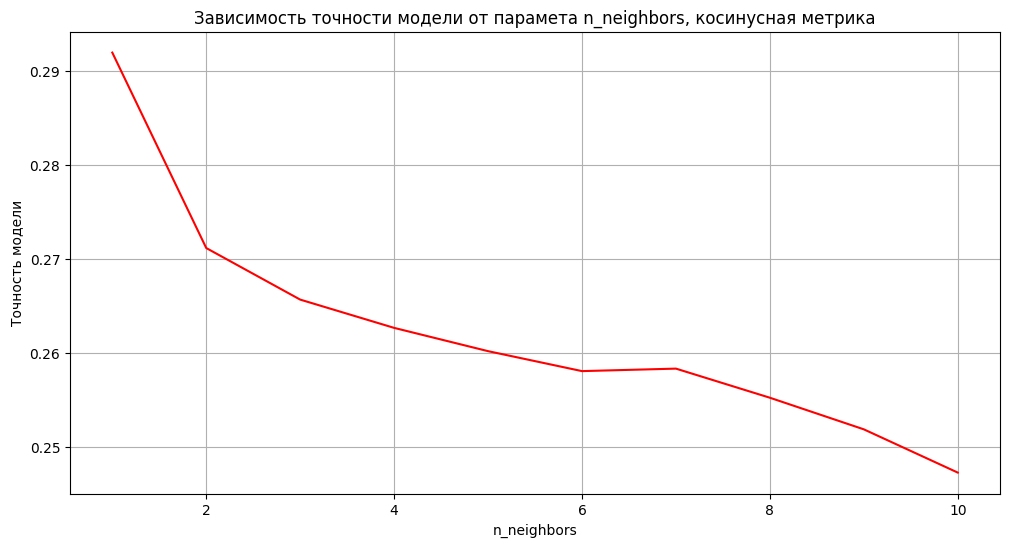

In [53]:
plt.figure(figsize=(12,6))
plt.plot(list(range(1, 11)), accs, 'red')
plt.title("Зависимость точности модели от парамета n_neighbors, косинусная метрика")
plt.xlabel("n_neighbors")
plt.ylabel("Точность модели")
plt.grid()
plt.show()

**Косинусная метрика работает лучше, это может быть связано с тем, что тексты в датасете разного рамера**

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tfidf_vectorizer = TfidfVectorizer()

In [56]:
data = newsgroups['data']
target = newsgroups['target']

In [57]:
data = tfidf_vectorizer.fit_transform(data)

In [58]:
accs = []
for k in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    cv_results = cross_validate(clf, data, target, cv=3, scoring='accuracy')
    accs.append(cv_results['test_score'].mean())

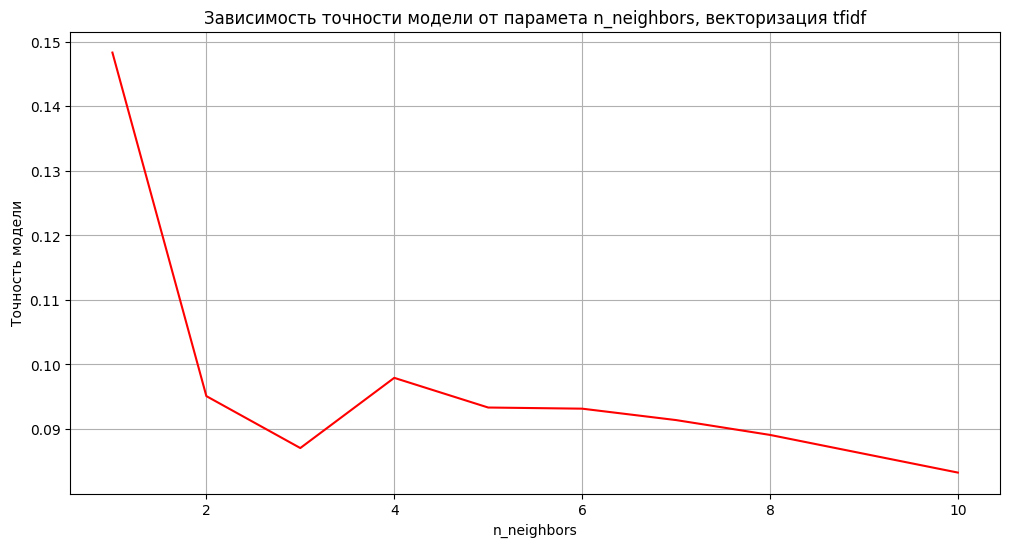

In [59]:
plt.figure(figsize=(12,6))
plt.plot(list(range(1, 11)), accs, 'red')
plt.title("Зависимость точности модели от парамета n_neighbors, векторизация tfidf")
plt.xlabel("n_neighbors")
plt.ylabel("Точность модели")
plt.grid()
plt.show()

**Качество при использовании векторизации  TF-IDF  упало**

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [66]:
test_newsgroups = fetch_20newsgroups(subset='test',remove=('headers','footers', 'quotes'))

In [68]:
test_data = test_newsgroups['data']
test_target = test_newsgroups['target']

In [69]:
test_data = vectorizer.transform(test_data)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [71]:
clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='cosine')
data = newsgroups['data']
target = newsgroups['target']
data = vectorizer.transform(data)
clf.fit(data, target)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=1)

In [72]:
preds = clf.predict(test_data)

In [73]:
print(f"Точность на тестовом наборе: {100 * accuracy_score(test_target, preds):.2f}%")

Точность на тестовом наборе: 23.31%


Точность на тестовой выборке может быть ниже из-за того, что тестовые данные имеют другое распределение чем тренировочные

# Линейные модели (5 баллов)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i)^2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [75]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        shuffled = np.hstack([X, y[..., None]])
        np.random.shuffle(shuffled)
        X = shuffled[:, :-1]
        y = shuffled[:, -1]

    n_batches = X.shape[0] // batch_size

    for i in range(n_batches):
        X_batch = X[i * batch_size: (i + 1) * batch_size]
        y_batch = y[i * batch_size: (i + 1) * batch_size]
        yield (X_batch, y_batch)

In [876]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, batch_size=1, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = None
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
        if not self.model_type in ['lin_reg', 'log_reg']:
            raise NotImplementedError
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            y_pred = X_batch @ self.weights
            loss = ((y_pred - y_batch) ** 2).mean() + (self.weights ** 2).sum() / self.C
            
        elif self.model_type == 'log_reg':
            y_pred = sigmoid(X_batch @ self.weights)
            loss = -(y_batch * np.log(y_pred) + (1 - y_batch) * np.log(1 - y_pred)).mean() + (self.weights ** 2).sum() / self.C
        
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        bs = X_batch.shape[0]
        if self.model_type == 'lin_reg':
            y_pred = X_batch @ self.weights
            loss_grad = (2 / bs) * (X_batch.T @ (y_pred - y_batch)) + 2 * self.weights / self.C
            
        elif self.model_type == 'log_reg':
            y_pred = sigmoid(X_batch @ self.weights)
            loss_grad = X_batch.T @ (y_pred - y_batch) + 2 * self.weights / self.C
        
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        
        pass
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Добавим третий признак, состоящий целимком из единиц, он нужен, чтобы создать свободный член у регрессии
        X = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])
        self.weights = np.random.rand(X.shape[1])
        
        # Для линейной регрессии преобразуем таргеты, чтобы они были -1 и 1, 
        # так как классы должны различаться знаком (сверх прямой - плюс, снизу - минус)
        if self.model_type == 'lin_reg':
            y = (y - 0.5) * 2
        
        n_batches = X.shape[0] // self.batch_size
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(n * n_batches + batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if self.model_type == 'lin_reg':
            y_pred = X @ self.weights
            
        elif self.model_type == 'log_reg':
            y_pred = sigmoid(X @ self.weights)
        
        return y_pred

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [640]:
def plot_decision_boundary(clf):
    xs = np.linspace(-4, 8, 2)
    plt.plot(xs, -clf.weights[0] * xs / clf.weights[1] - clf.weights[2] / clf.weights[1], label='модель')

In [641]:
def plot_optimal_boundary(coefs):
    xs = np.linspace(-4, 8, 2)
    plt.plot(xs, -coefs[0] * xs / coefs[1] - coefs[2] / coefs[1], '--', color='black', label='аналитическое решение')

In [723]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [724]:
my_batch_generator = batch_generator

my_clf = MySGDClassifier(batch_generator=my_batch_generator, 
                         batch_size=8,
                             max_epoch=10,
                             alpha=0.01,
                             model_type='lin_reg', 
                             C=100)

my_clf = my_clf.fit(X, y)

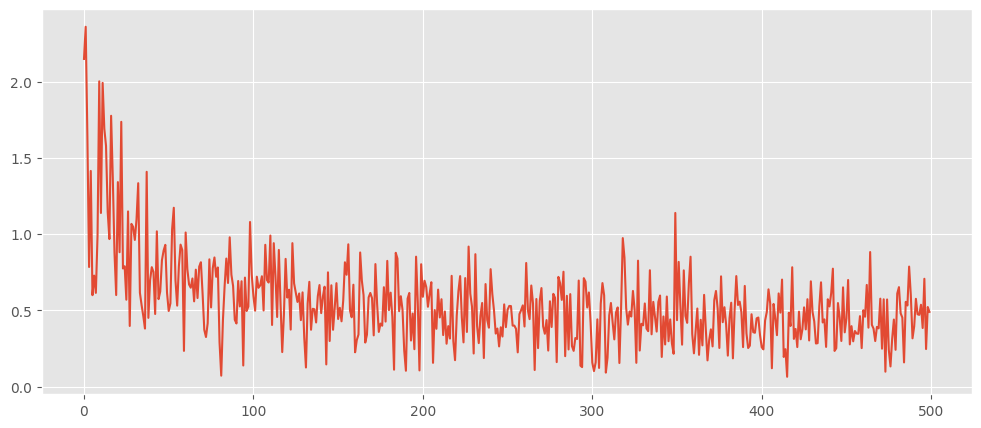

In [725]:
logs = my_clf.errors_log
plt.plot(logs['iter'], logs['loss'])

Сравним результат с аналитическим решением

In [726]:
X1 = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])

In [727]:
k_anal = np.linalg.inv(X1.T @ X1) @ X1.T @ (y)

In [728]:
print(f"Аналитическая разделяющая прямая: y = {k_anal[1] / k_anal[0]:.3f} x + {k_anal[2] / k_anal[1]:.3f}")

Аналитическая разделяющая прямая: y = -1.187 x + 3.680


In [729]:
k_clf = my_clf.weights

In [730]:
print(f"Обученная разделяющая прямая: y = {k_clf[1] / k_clf[0]:.3f} x + {k_clf[2] / k_clf[1]:.3f}")

Обученная разделяющая прямая: y = -0.993 x + 3.945


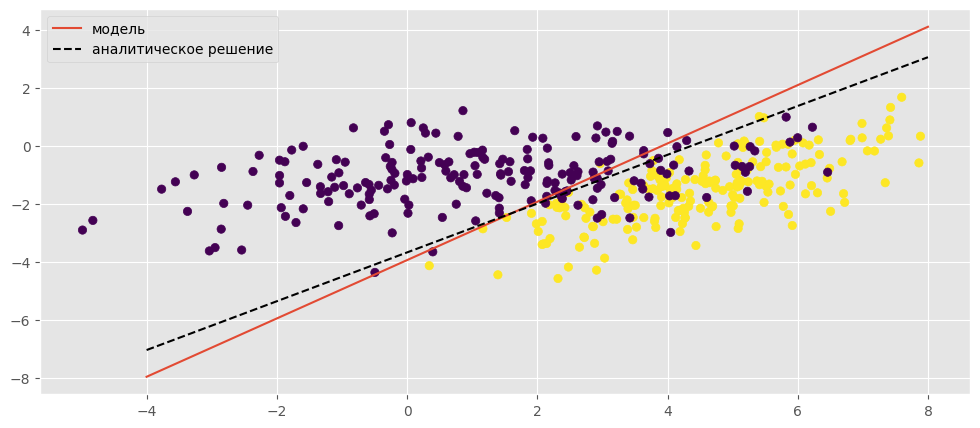

In [731]:
plot_decision_boundary(my_clf)
plot_optimal_boundary(k_anal)
plt.scatter(X[:,0], X[:,1], c=y)
plt.legend()

Веса, к которым сходится обучение, совпадает с аналитическим решением. Это говорит о корректности обучения.

In [780]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [781]:
my_batch_generator = batch_generator

my_clf = MySGDClassifier(batch_generator=my_batch_generator, 
                         batch_size=32,
                             max_epoch=10,
                             alpha=0.01,
                             model_type='log_reg', 
                             C=1000)

my_clf = my_clf.fit(X, y)

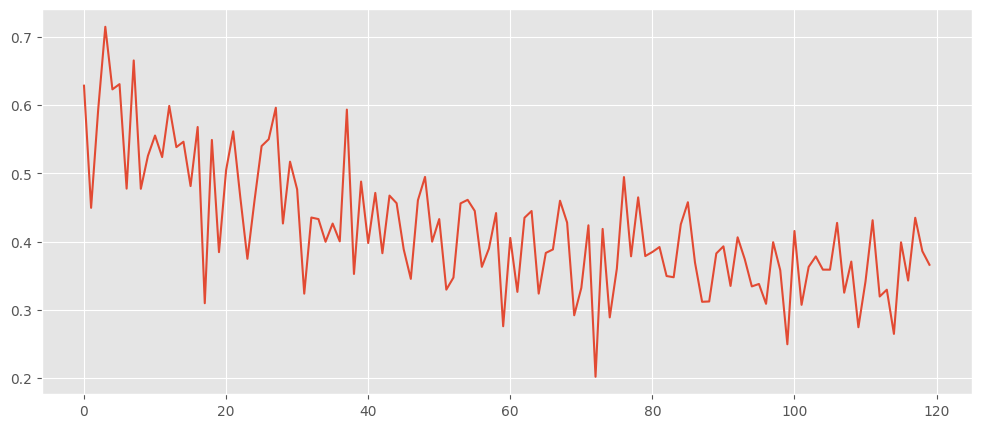

In [782]:
logs = my_clf.errors_log
plt.plot(logs['iter'], logs['loss'])

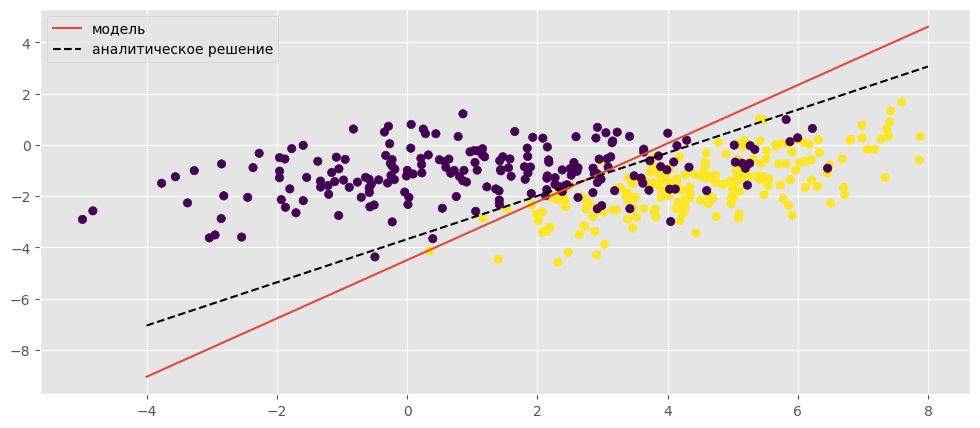

In [784]:
plot_decision_boundary(my_clf)
plot_optimal_boundary(k_anal)
plt.scatter(X[:,0], X[:,1], c=y)
plt.legend()

In [785]:
print(f"Аналитическая разделяющая прямая: y = {k_anal[1] / k_anal[0]:.3f} x + {k_anal[2] / k_anal[1]:.3f}")

Аналитическая разделяющая прямая: y = -1.187 x + 3.680


In [786]:
k_clf = my_clf.weights

In [787]:
print(f"Обученная разделяющая прямая: y = {k_clf[1] / k_clf[0]:.3f} x + {k_clf[2] / k_clf[1]:.3f}")

Обученная разделяющая прямая: y = -0.879 x + 4.496


Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [906]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

In [907]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [908]:
y = y.astype(np.float64)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

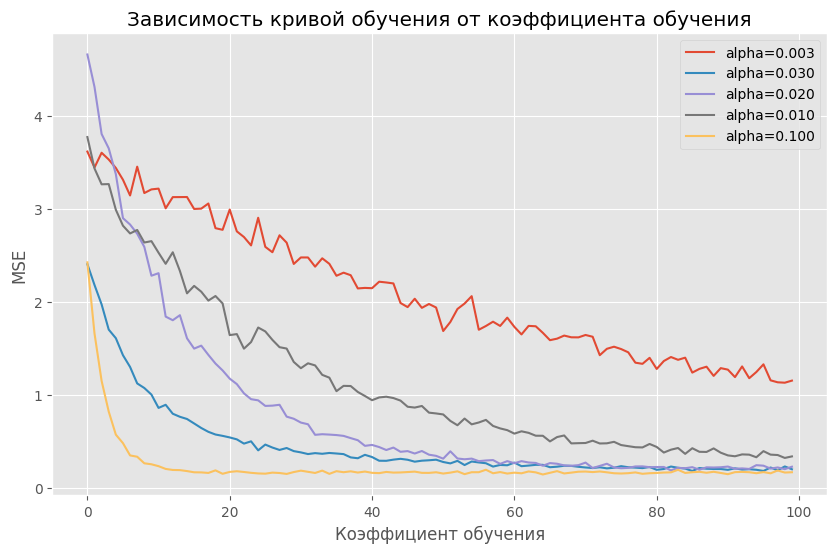

In [910]:
plt.figure(figsize=(10,6))
plt.title("Зависимость кривой обучения от коэффициента обучения")
plt.xlabel("Коэффициент обучения")
plt.ylabel("MSE")
for alpha in [3e-3, 3e-2, 2e-2, 1e-2, 1e-1]:
    my_batch_generator = batch_generator

    my_clf = MySGDClassifier(batch_generator=my_batch_generator, 
                            batch_size=1000,
                                max_epoch=1,
                                alpha=alpha,
                                model_type='lin_reg', 
                                C=1000)

    my_clf = my_clf.fit(X, y)
    logs = my_clf.errors_log
    plt.plot(logs['iter'], logs['loss'], label=f'alpha={alpha:.3f}')
plt.legend(loc=0)
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

Чем больше alpha, тем быстрее сходится, но когда alpha слишком большой, модель недообучается

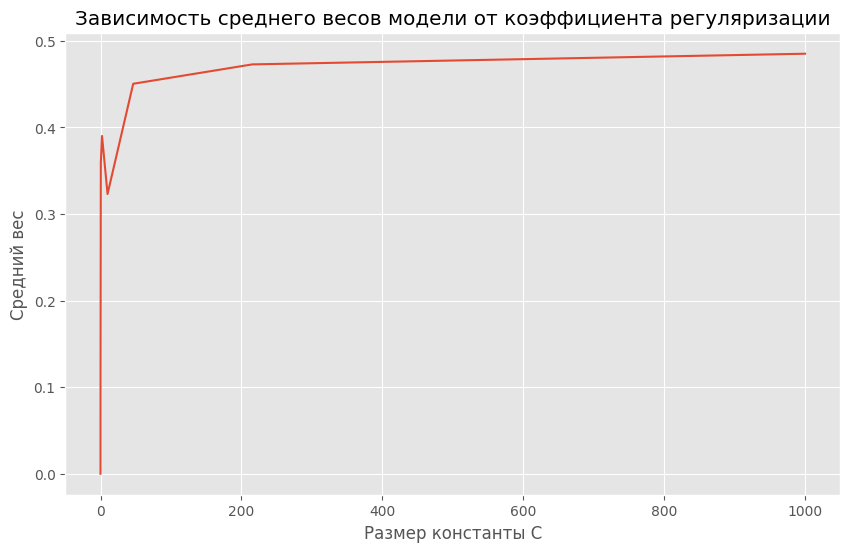

In [923]:
plt.figure(figsize=(10,6))
plt.title("Зависимость среднего весов модели от коэффициента регуляризации")
plt.xlabel("Размер константы С")
plt.ylabel("Средний вес")
weights_mean = []
for C in np.logspace(3, -3, 10):
    my_batch_generator = batch_generator

    my_clf = MySGDClassifier(batch_generator=my_batch_generator, 
                            batch_size=1000,
                                max_epoch=1,
                                alpha=0.0005,
                                model_type='lin_reg', 
                                C=C)

    my_clf = my_clf.fit(X, y)
    weights_mean.append(np.abs(my_clf.weights).mean())
    
plt.plot(np.logspace(3, -3, 10), weights_mean)
plt.show()

Чем больше константа C, тем больше допустимый вес, что логично

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Да, я доволен